In [43]:
import numpy as np
import scipy as sp
from scipy import io as spio
from scipy import ndimage
from numpy import fft
from sklearn.decomposition import PCA, FastICA, NMF
import time
import os

In [138]:
from ipywidgets import widgets  
from IPython.display import display
from IPython.display import HTML

In [139]:
import matplotlib.pylab as plt
from matplotlib import animation
import matplotlib as mpl
% matplotlib inline

In [46]:
from __future__ import division

Data is obtained from the CRCNS website - ssc-1 data set.

Simon Peron, Jeremy Freeman, Vijay Iyer, Karel Svoboda (2014);  Calcium imaging data from vibrissal S1 neurons in adult mice performing a pole localization task. CRCNS.org.
http://dx.doi.org/10.6080/K000001D

In [76]:
# read the data
data_path = os.path.join('..','data','SvobodaLabSSCData')
fov_01001_data = spio.loadmat(os.path.join(data_path,'fov_01001_data.mat'))
ts = fov_01001_data['Data']

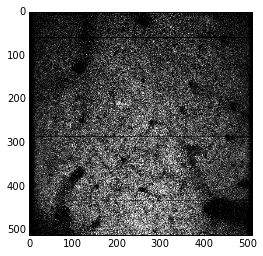

In [77]:
def displayImByFrame(frame):
    
    plt.imshow(ts[:,:,frame],cmap = 'gray',vmin = 0,vmax = 350)

a_slider = widgets.IntSlider(min=0, max=(ts.shape[-1]-1))
w = widgets.interactive(displayImByFrame,frame=a_slider)
display(w)


Calculating $(F - F_0)/F_0$.

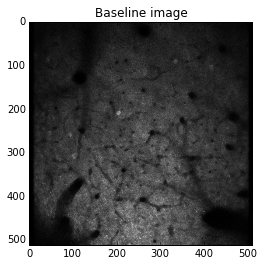

In [55]:
# Creating the baseline signal (we will use the mean - median is better to exclude spikes but it also has more zeros)
ts_0 = np.mean(ts,2)
plt.imshow(ts_0,cmap = 'gray')
plt.title('Baseline image')

45.0
-1.0


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


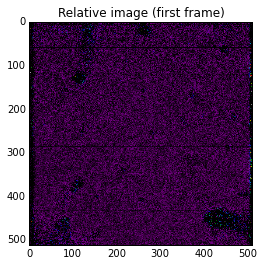

In [56]:
# Creating the relative signal
ts_rel = (ts - ts_0.reshape((ts.shape[0],ts.shape[1],1))).astype('float')/ts_0.reshape((ts.shape[0],ts.shape[1],1)).astype('float')

# Note ts_rel will contain nan's since some of the values of ts_0 are equal to zero.

# We will convert those nan's to zero:

# I want to mask into first two dimensions.
ts_rel[np.isnan(ts_rel)]=0

# One could get also infs (when using the median)

# We can set those to zero, but maybe there is a better approach 
# ts_rel[np.isinf(ts_rel)]=0

print(np.max(ts_rel))
print(np.min(ts_rel))


plt.imshow(ts_rel[:,:,0],cmap = 'gray',vmin = np.min(ts_rel[:,:,0]),vmax = np.max(ts_rel[:,:,0]))
# plt.imshow(ts_rel[:,:,20],cmap = 'gray',vmin = -40,vmax = 100)
# plt.imshow(ts_rel[:,:,0])

#plt.plot(ts_rel.reshape(ts.shape[0]*ts.shape[1],ts.shape[2]).T)
plt.imshow(ts_rel[:,:,0],cmap = 'spectral')
plt.title('Relative image (first frame)')

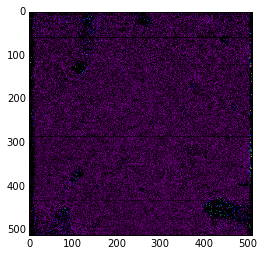

In [102]:
def displayImByFrame(frame):
    
    plt.imshow(ts_rel[:,:,frame],cmap = 'spectral',vmin = np.min(ts_rel),vmax = np.max(ts_rel))

a_slider = widgets.IntSlider(min=0, max=(ts.shape[-1]-1))
w = widgets.interactive(displayImByFrame,frame=a_slider)
display(w)

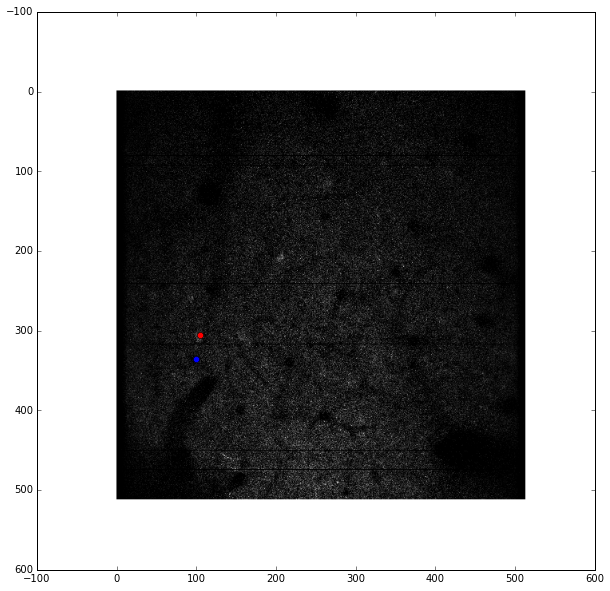

In [58]:
# plot a possible cell location extracted by hand
plt.figure(figsize = (10,10))
fig = plt.imshow(ts[:,:,2],cmap = 'gray')
plt.plot(105,305,'ro')
plt.plot(100,335,'bo')

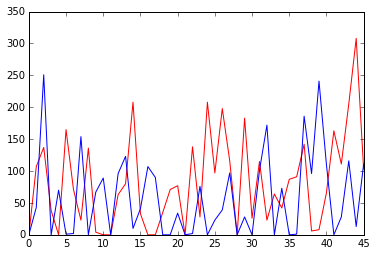

In [59]:
# Look at the signal at the extracted cell
# and one further away
# plt.plot(ts_rel[108,308,:])
plt.plot(ts[108,308,:],'r')
plt.plot(ts[100,335,:],'b')

Remove noise and neuropil from noise raw data.

#### Noise Removal
The noise in the images looks like a shot noise, so we use a median filter to remove it. We can apply the filter from the whole image stack by using the filters from the ndimage module. 

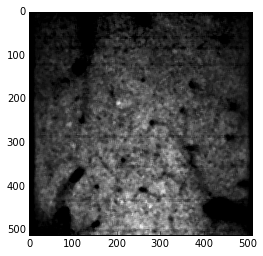

In [60]:
ts_filtered = ndimage.median_filter(ts,(7,7,1))
plt.imshow(ts_filtered[:,:,0],cmap = 'gray')

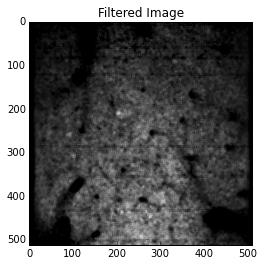

In [61]:
def displayImByFrame(frame):
    
    plt.imshow(ts_filtered[:,:,frame],cmap = 'gray',vmin = 0,vmax = 350)
    plt.title('Filtered Image')

a_slider = widgets.IntSlider(min=0, max=(ts.shape[-1]-1))
w = widgets.interactive(displayImByFrame,frame=a_slider)
display(w)


In [62]:
# time series for individual pixels (# Pixels x # Time Points)
# We will do the analysis on the filtered images!!!
ts_2D = ts_filtered.reshape(ts.shape[0]*ts.shape[1],ts.shape[2])
ts_2D.shape

(262144, 46)

#### Principal Component Analysis

In [63]:
m = 20 # set the number of components

In [64]:
pca = PCA(n_components = m)
pca.fit(ts_2D)

PCA(copy=True, n_components=20, whiten=False)

In [65]:
n = pca.components_.shape[1]

offset = np.reshape(np.tile(np.arange(m),n),(n,m))

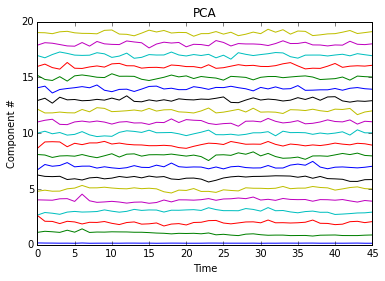

In [66]:
plt.plot(pca.components_.T+offset)
plt.title("PCA")
plt.xlabel("Time")
plt.ylabel("Component #")

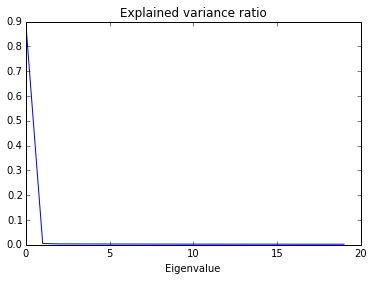

In [67]:
plt.plot(pca.explained_variance_ratio_)
plt.title("Explained variance ratio")
plt.xlabel("Eigenvalue")

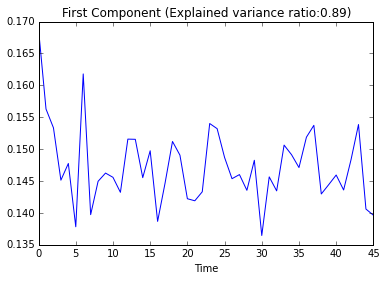

In [68]:
plt.plot(pca.components_[0,:])
plt.title("First Component (Explained variance ratio:" + str(round(pca.explained_variance_ratio_[0],2))+ ")")
plt.xlabel("Time")

In [69]:
# plt.imshow(np.reshape(pca.components_,(ts.shape[0],ts.shape[1],m))[:,:,0],cmap = 'gray')

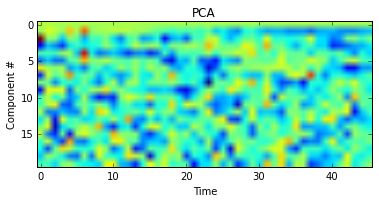

In [70]:
plt.imshow(pca.components_)
plt.title("PCA")
plt.xlabel("Time")
plt.ylabel("Component #")

In [71]:
# representation in the PCA basis
ts_2D_transformed = pca.transform(ts_2D)
print(ts_2D_transformed.shape)

# convert back to 3D array
ts_transformed = np.reshape(ts_2D_transformed,(ts.shape[0],ts.shape[1],m))

(262144, 20)


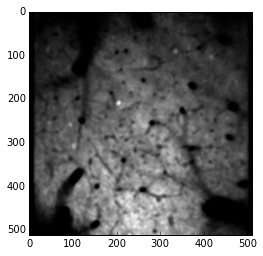

In [78]:
# visualize projection coefficients
def displayImByFrame(comp):
    
    plt.imshow(ts_transformed[:,:,comp],cmap = 'gray')

a_slider = widgets.IntSlider(min=0, max=(ts_transformed.shape[-1]-1))
w = widgets.interactive(displayImByFrame,comp=a_slider)
display(w)

In [79]:
# calculate the relative effect 
proportions = np.abs(ts_2D_transformed)/np.reshape(np.sum(np.abs(ts_2D_transformed),axis = 0),(1,m))
proportions = np.reshape(proportions,(ts.shape[0],ts.shape[1],m))

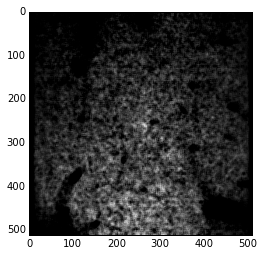

In [148]:
# visualize proportions
def displayImByFrame(comp):
    
    plt.imshow(proportions[:,:,comp],cmap = 'gray')

a_slider = widgets.IntSlider(min=0, max=(ts_transformed.shape[-1]-1))
w = widgets.interactive(displayImByFrame,comp=a_slider)
display(w)

#### Independent Component Analysis 

In [81]:
ica = FastICA(n_components = m)
ica.fit(ts_2D)

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=20, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

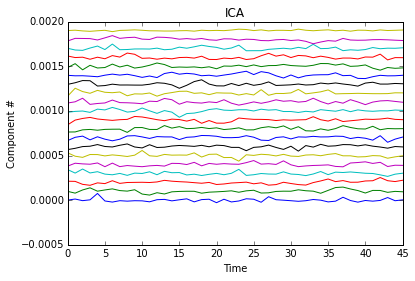

In [82]:
plt.plot(ica.components_.T + 0.0001*offset)
plt.title("ICA")
plt.xlabel("Time")
plt.ylabel("Component #")

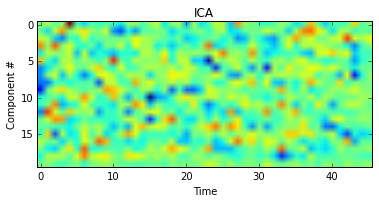

In [83]:
plt.imshow(ica.components_)
plt.title("ICA")
plt.xlabel("Time")
plt.ylabel("Component #")

In [140]:
# get the coefficients
ts_2D_transformed = ica.transform(ts_2D)
# get the proportions
proportions = np.abs(ts_2D_transformed)/np.reshape(np.sum(np.abs(ts_2D_transformed),axis = 0),(1,m))
proportions = np.reshape(proportions,(ts.shape[0],ts.shape[1],m))

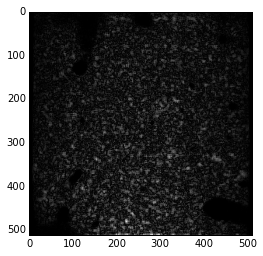

In [141]:
# visualize contribution for each component
def displayImByFrame(comp):
    
    plt.imshow(proportions[:,:,comp],cmap = 'gray')

a_slider = widgets.IntSlider(min=0, max=(ts_transformed.shape[-1]-1))
w = widgets.interactive(displayImByFrame,comp=a_slider)
display(w)

#### Nonnegative Matrix Decomposition

In [142]:
nmf = NMF(n_components=m, init='random', random_state=0)
nmf.fit(ts_2D) 

NMF(alpha=0.0, beta=1, eta=0.1, init='random', l1_ratio=0.0, max_iter=200,
  n_components=20, nls_max_iter=2000, random_state=0, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

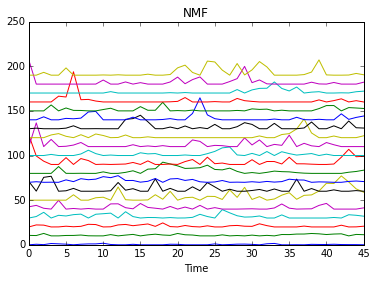

In [143]:
plt.plot(nmf.components_.T + offset*10)
plt.title("NMF")
plt.xlabel("Time")

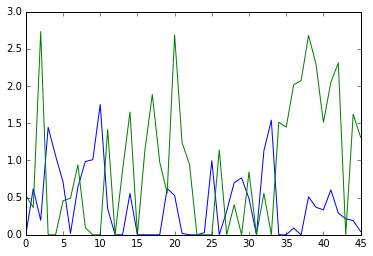

In [144]:
plt.plot(nmf.components_[0:2].T)

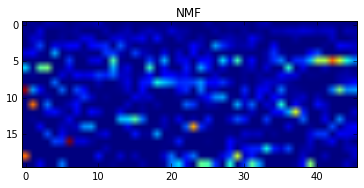

In [145]:
plt.imshow(nmf.components_)
plt.title("NMF")

In [146]:
# get the coefficients
ts_2D_transformed = nmf.transform(ts_2D)
# get the proportions
proportions = np.abs(ts_2D_transformed)/np.reshape(np.sum(np.abs(ts_2D_transformed),axis = 0),(1,m))
proportions = np.reshape(proportions,(ts.shape[0],ts.shape[1],m))

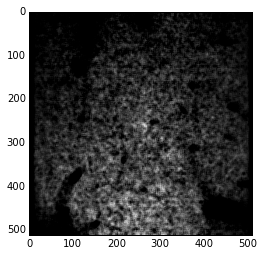

In [147]:
# visualize proportions
def displayImByFrame(comp):
    
    plt.imshow(proportions[:,:,comp],cmap = 'gray')

a_slider = widgets.IntSlider(min=0, max=(ts_transformed.shape[-1]-1))
w = widgets.interactive(displayImByFrame,comp=a_slider)
display(w)